### Author Statement
This project has been developed by Mustafa Neguib who is a student of
Masters of Information Technology at The University of Melbourne and has
student id 922939.
You can contact the developer at mneguib@student.unimelb.edu.au


In [1]:
from assign2_modules import *
import os
import numpy as np
import geopandas
import pandas
from shapely import geometry
from shapely import wkt
from shapely.ops import triangulate
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.cluster import DBSCAN
from sklearn import metrics
import libpysal as lps
import mapclassify as mc
import esda
import seaborn as sbn
import random
import folium

# In order to make the function to_crs work I had to define the PROJ_LIB to the path given below.
# For some reason the PROJ_LIB environment variable is empty.
# This is required for Task 2 Question 3 to work when we have to transform the SA2 shape file to 4326 crs
# Change to a path on your own computer
os.environ['PROJ_LIB'] = r"C:\Users\Mustafa Neguib\Anaconda3\pkgs\proj4-6.0.0-ha7a8c7b_0\Library\share\proj"

# Task 1

In [2]:
# The lists of the form *_required_columns list the columns that are required in order to read the appropriate csv file.
# If the csv file does not have the correct number of columns or the columns with the names then we can not read the file
# as it does not contain the correct data.

# 'ACCIDENT.csv'
accident_required_columns = ["ACCIDENT_NO", "ACCIDENTDATE", "ACCIDENTTIME", "ACCIDENT_TYPE", "Accident Type Desc",
                                 "DAY_OF_WEEK", "Day Week Description", "DCA_CODE", "DCA Description", "DIRECTORY",
                                 "EDITION", "PAGE", "GRID_REFERENCE_X", "GRID_REFERENCE_Y", "LIGHT_CONDITION",
                                 "Light Condition Desc", "NODE_ID", "NO_OF_VEHICLES", "NO_PERSONS", "NO_PERSONS_INJ_2",
                                 "NO_PERSONS_INJ_3", "NO_PERSONS_KILLED", "NO_PERSONS_NOT_INJ", "POLICE_ATTEND",
                                 "ROAD_GEOMETRY", "Road Geometry Desc", "SEVERITY", "SPEED_ZONE"]
accidents_data_frame = read_csv_file("ACCIDENT.csv", accident_required_columns)

# 'ACCIDENT_CHAINAGE.csv'
accident_chainage_required_columns = ["Node Id", "Route No", "Chainage Seq", "Route Link", "Chainage"]

# 'ACCIDENT_EVENT.csv'
accident_event_required_columns = ["ACCIDENT_NO", "EVENT_SEQ_NO", "EVENT_TYPE", "Event Type Desc", "VEHICLE_1_ID",
                                      "VEHICLE_1_COLL_PT", "Vehicle 1 Coll Pt Desc", "VEHICLE_2_ID",
                                      "VEHICLE_2_COLL_PT", "Vehicle 2 Coll Pt Desc", "PERSON_ID", "OBJECT_TYPE",
                                      "Object Type Desc"]

# 'ACCIDENT_LOCATION.csv'
accident_location_required_columns = ["ACCIDENT_NO", "NODE_ID", "ROAD_ROUTE_1", "ROAD_NAME", "ROAD_TYPE",
                                          "ROAD_NAME_INT", "ROAD_TYPE_INT", "DISTANCE_LOCATION", "DIRECTION_LOCATION",
                                          "NEAREST_KM_POST", "OFF_ROAD_LOCATION"]
accidents_location_data_frame = read_csv_file("ACCIDENT_LOCATION.csv", accident_location_required_columns)

# 'ATMOSPHERIC_COND.csv'
atmospheric_con_required_columns = ["ACCIDENT_NO", "ATMOSPH_COND", "ATMOSPH_COND_SEQ", "Atmosph Cond Desc"]
atomospheric_con_data_frame = read_csv_file('ATMOSPHERIC_COND.csv', atmospheric_con_required_columns)

# 'NODE_ID_COMPLEX_INT_ID.csv'
node_id_complex_required_columns = ["ACCIDENT_NO", "NODE_ID", "COMPLEX_INT_NO"]

# 'NODE.csv'
node_required_column = ["ACCIDENT_NO", "NODE_ID", "NODE_TYPE", "AMG_X", "AMG_Y", "LGA_NAME", "Lga Name All",
                            "Region Name", "Deg Urban Name", "Lat", "Long", "Postcode No"]
node_data_frame = read_csv_file("NODE.csv", node_required_column)
    
# 'PERSON.csv'
person_required_columns = ["ACCIDENT_NO", "PERSON_ID", "VEHICLE_ID", "SEX", "AGE", "Age Group", "INJ_LEVEL",
                           "Inj Level Desc", "SEATING_POSITION", "HELMET_BELT_WORN", "ROAD_USER_TYPE",
                           "Road User Type Desc", "LICENCE_STATE", "PEDEST_MOVEMENT", "POSTCODE", "TAKEN_HOSPITAL",
                           "EJECTED_CODE"]
person_data_frame = read_csv_file("PERSON.csv", person_required_columns)

# 'ROAD_SURFACE_COND.csv'
road_surface_required_columns = ["ACCIDENT_NO", "SURFACE_COND", "Surface Cond Desc", "SURFACE_COND_SEQ"]
road_surface_data_frame = read_csv_file('ROAD_SURFACE_COND.csv', road_surface_required_columns)

# 'VEHICLE.csv'
vehicle_required_columns = ["ACCIDENT_NO", "VEHICLE_ID", "VEHICLE_YEAR_MANUF", "VEHICLE_DCA_CODE",
                                "INITIAL_DIRECTION", "ROAD_SURFACE_TYPE", "Road Surface Type Desc", "REG_STATE",
                                "VEHICLE_BODY_STYLE", "VEHICLE_MAKE", "VEHICLE_MODEL", "VEHICLE_POWER", "VEHICLE_TYPE",
                                "Vehicle Type Desc", "VEHICLE_WEIGHT", "CONSTRUCTION_TYPE", "FUEL_TYPE", "NO_OF_WHEELS",
                                "NO_OF_CYLINDERS", "SEATING_CAPACITY", "TARE_WEIGHT", "TOTAL_NO_OCCUPANTS",
                                "CARRY_CAPACITY", "CUBIC_CAPACITY", "FINAL_DIRECTION", "DRIVER_INTENT",
                                "VEHICLE_MOVEMENT", "TRAILER_TYPE", "VEHICLE_COLOUR_1", "VEHICLE_COLOUR_2",
                                "CAUGHT_FIRE", "INITIAL_IMPACT", "LAMPS", "LEVEL_OF_DAMAGE", "OWNER_POSTCODE",
                                "TOWED_AWAY_FLAG", "TRAFFIC_CONTROL", "Traffic Control Desc"]
vehicles_data_frame = read_csv_file('VEHICLE.csv', vehicle_required_columns)

C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
years = set()
accident_types_desc = set()
number_accidents_per_years = {}
vehicle_types_desc = set()
html_content = ""

### Question 1 and 2

In [4]:
html_content, accidents_data_frame_few_columns = calculate_accident_statistics(accidents_data_frame)
#html_content = html

Average number of accidents per year: 13788.55
The second most common type of accident in all the recorded years is 'Collision with a fixed object', and the percentage of the accidents that belong to this type is 16.56%


### Question 3

In [5]:
html_string=""
html_string, accidents_with_vehicles =  generate_accidents_by_type_and_year(accidents_data_frame_few_columns, vehicles_data_frame)
html_content += html_string

### Question 4

In [6]:
html_content += compute_top10_lga_accidents(accidents_data_frame, node_data_frame)

### Question 5

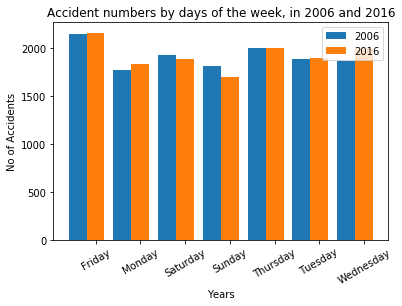

In [7]:
# TODO: I have to sort the days of the week in the correct order
html_content += plot_accidents_by_day_week(accidents_data_frame)

### Question 6

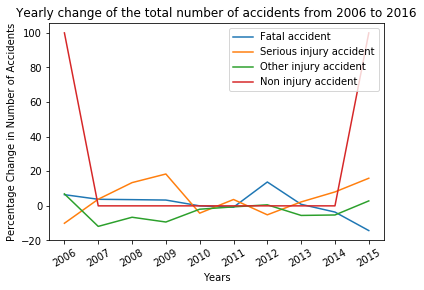

In [8]:
html_content += plot_accidents_by_severity_year(accidents_data_frame)
write_to_file(html_content, 'task1_922939.html','Task 1 922939')

# Task 2

### Question 1

In [9]:
# This function combines the three provided data frames and builds the resulting shape file which is then saved to the disk
build_accident_locations_shape_file(accidents_data_frame, vehicles_data_frame, node_data_frame)

### Question 2

In [10]:
# I am reading in the AccidentsLocation shape file that was built in Question 1
# There is a limitation in shapefiles that the column names must be less than or equal to 10 characters in length. Names longer than this, are trunctaed to 10 characters.
# In the original accidents_locations data frame the column AccidentNu was AccidentNumber and so on.
required_columns = ['AccidentNu', 'DayOfWeek', 'VehicleTyp', 'SevereAcci', 'geometry']
accidents_locations = read_shape_file('output/AccidentsLocation.shp', required_columns)
build_weekday_weekend_shape_files(accidents_locations)

### Question 3

In [11]:
# SA2 shape file contains the geometries in 2016 of Australia. Do note that we only need a small subset of what we have. The extraction of the subset has been handled in this function.
required_columns = ['SA2_MAIN16', 'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16',
       'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16',
       'STE_NAME16', 'AREASQKM16', 'geometry']
sa2 = read_shape_file('SA2_2016_AUST.shp', required_columns)

In [12]:
# This function uses sjoin and is dramatically faster and (takes 17 seconds to complete its execution) than the other function add_sa2_names_to_accidents_locations_shape_file which is an alternative to this function but is much slower
# I am calling this function for practical reasons and not to spend too much time waiting for the code to run.
accidents_locations, sa2_areas_of_interest = add_sa2_names_to_accidents_locations_shape_file_sjoin(sa2)

C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [13]:
# This function takes an average of 5 minutes 30 seconds. An explanation for the long execution time has been givenin the function's documentation.
#accidents_locations, sa2_areas_of_interest = add_sa2_names_to_accidents_locations_shape_file(sa2)

# Task 3

### Spatial Temporal Visual Analysis (Basic)

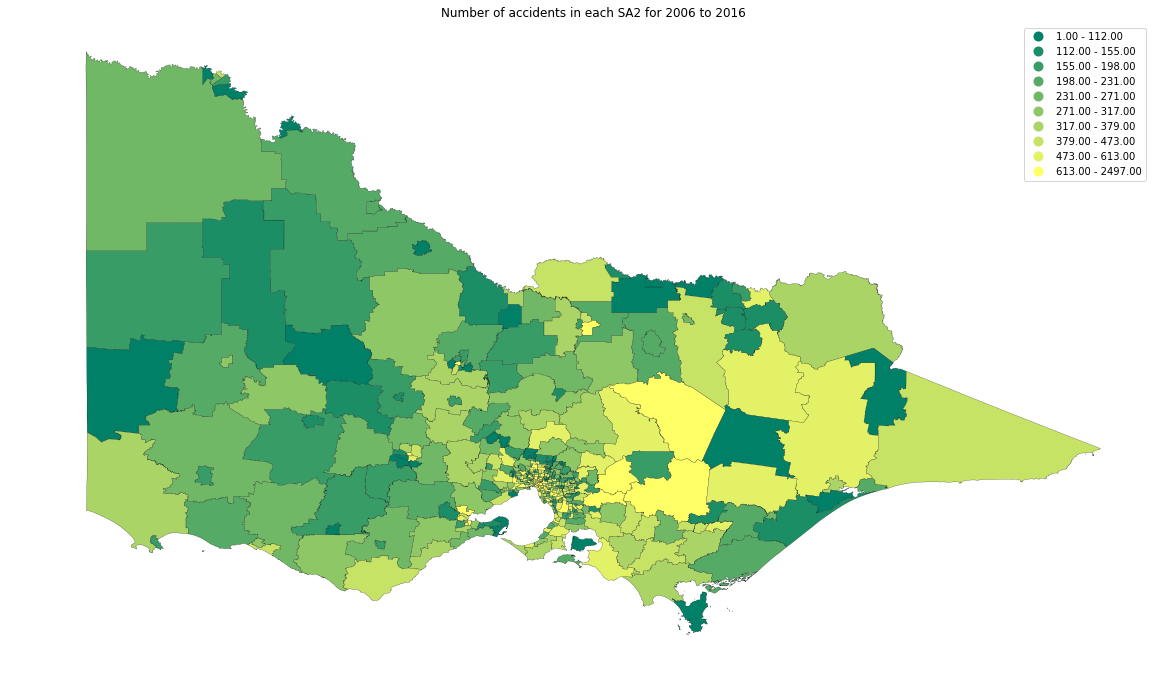

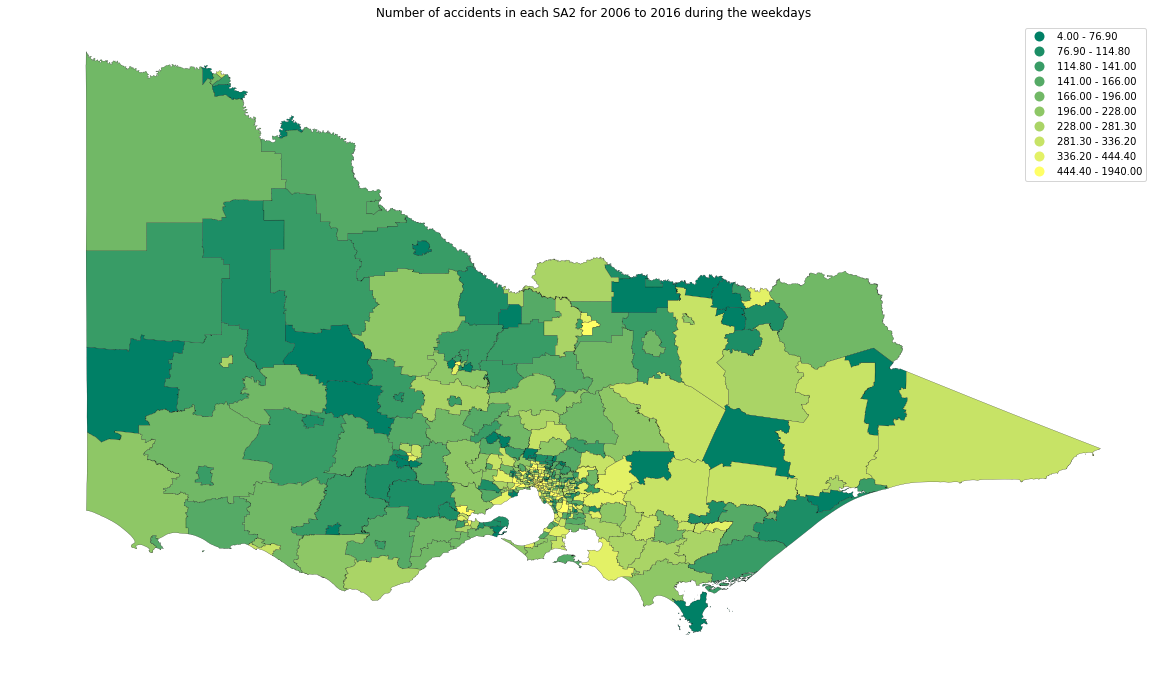

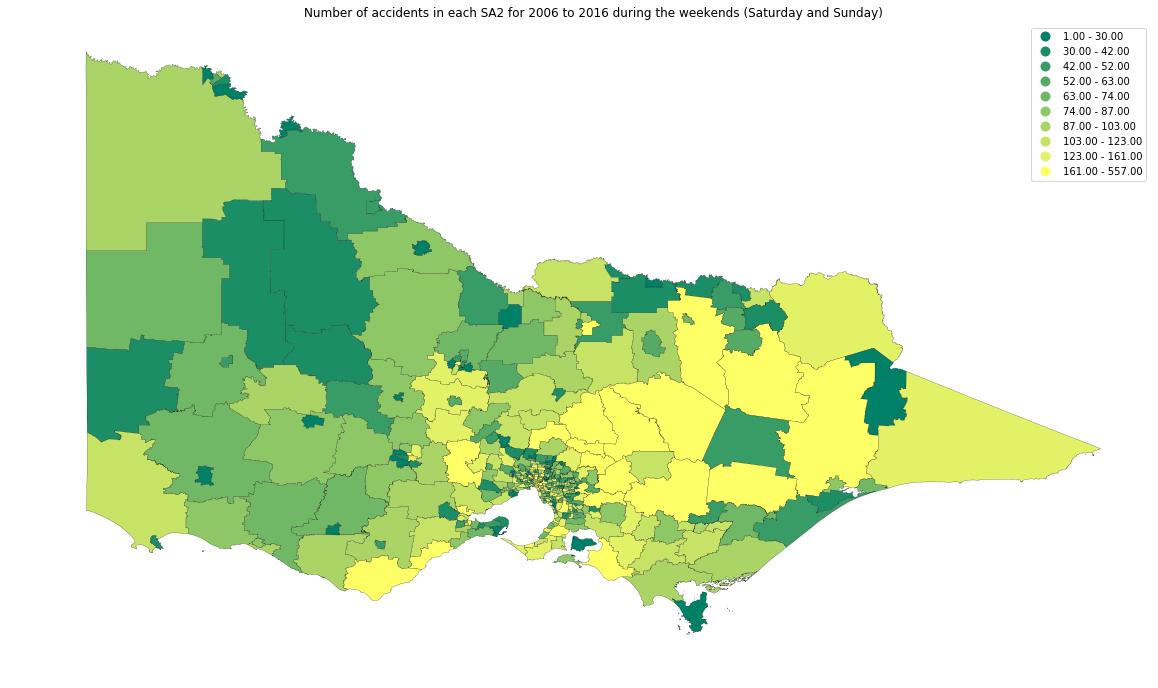

In [14]:
html_content=""
html_content, sa2_with_accident_counts = spatial_visual_analysis(accidents_locations,sa2_areas_of_interest, html_content)

### Spatial Autocorellation Calculation (Advanced)

C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\libpysal\weights\weights.py:168: UserWarning: There are 2 disconnected observations 
  Island ids: 86, 89
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 86, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')


C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\libpysal\weights\weights.py:168: UserWarning: There are 2 disconnected observations 
  Island ids: 86, 89
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


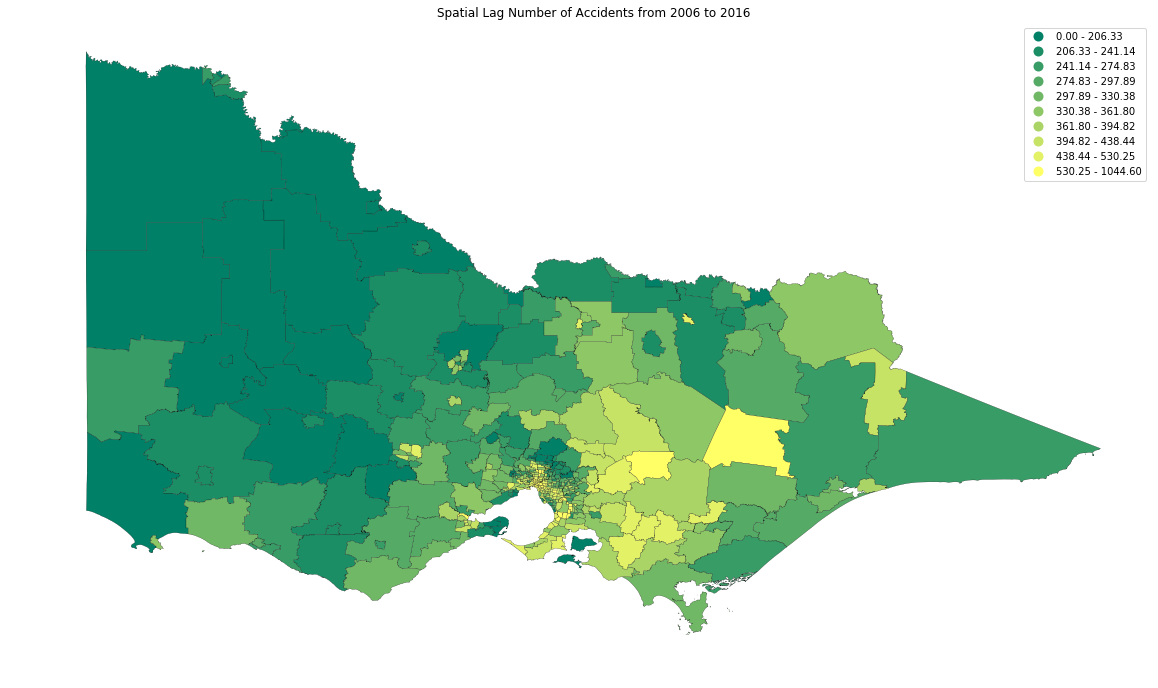

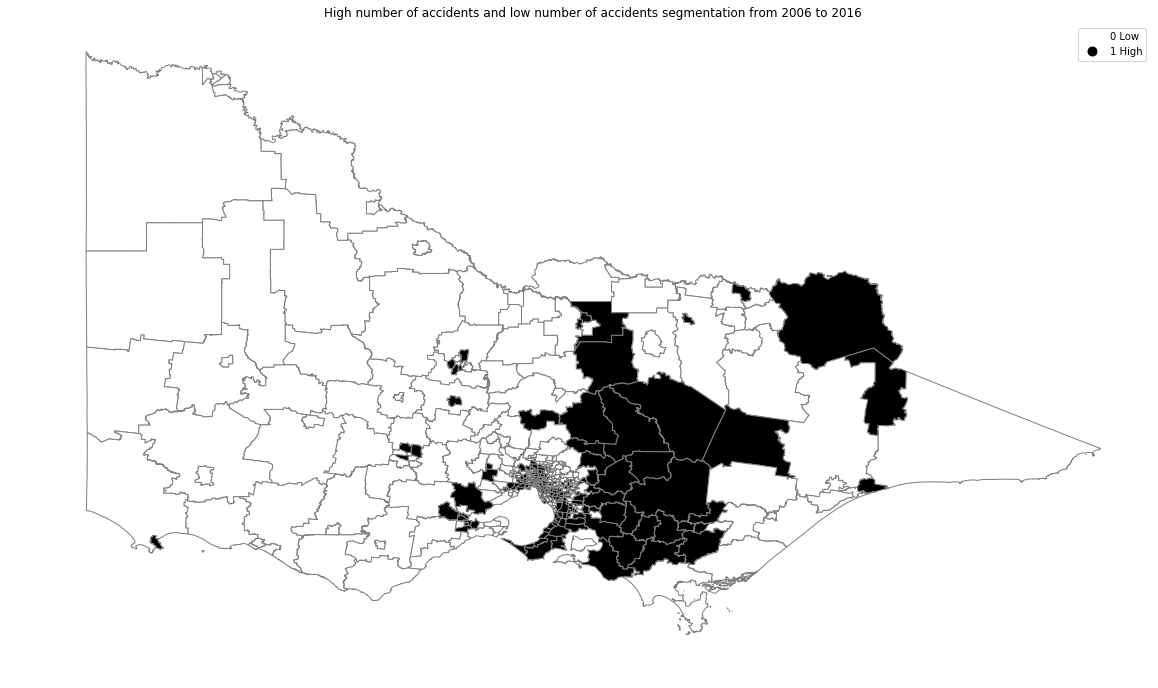

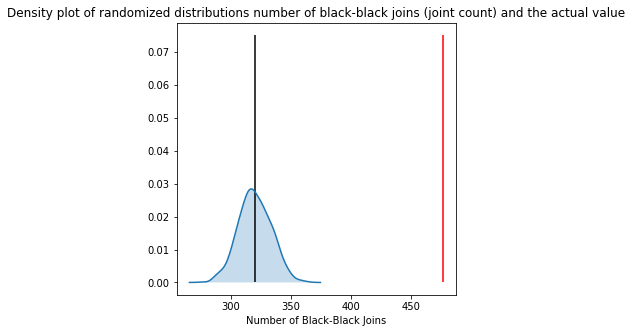

In [15]:
html_content, sa2_with_accident_counts = spatial_autocorrelation(sa2_with_accident_counts, html_content)

### Clustering Analysis (More Advanced)

In [16]:
group_by_num_parties, group_by_atmos_surface, m, group_by_age_group, group_by_sex, group_by_helmet_worn, coords, db,accidents_from_max_accidents_sa2, group_by_atmos_cond, group_by_road_surface, html_content = clustering_analysis(accidents_location_data_frame, road_surface_data_frame, atomospheric_con_data_frame, person_data_frame, accidents_locations, sa2_with_accident_counts, html_content)
m

C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))
D:\university of melbourne lectures\semester 4\Spatial Information Programming\Assignments\Assignment 2\notebook\project\assign2_modules.py:1331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  classify_helmet_belt_worn)


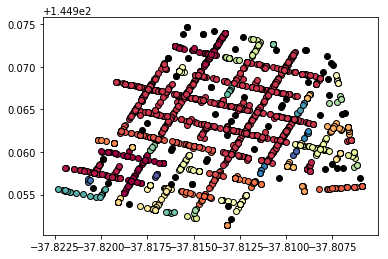

In [17]:
plot(coords, db)

-0.899849793853915


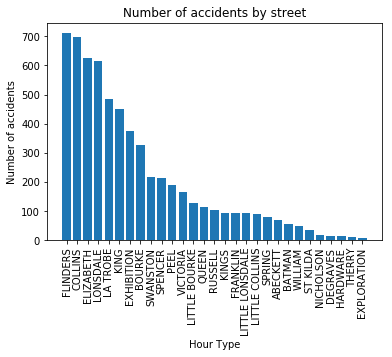

In [18]:
np.mean(group_by_data(accidents_from_max_accidents_sa2, ['ROAD_NAME'])['count'])
streets = group_by_data(accidents_from_max_accidents_sa2, ['ROAD_NAME'])
streets = streets.reset_index(drop=True).sort_values('count', ascending=False)

median = np.median(streets['count'])
streets_greater_than_median=streets[streets['count']>median]
streets_accidents=list(streets_greater_than_median['ROAD_NAME'])
count_streets_accidents=list(streets_greater_than_median['count'])
print(calculate_correlation_coefficient(np.arange(len(streets_accidents)),count_streets_accidents))
plot_bar_plot(streets_accidents,count_streets_accidents, 'Hour Type', 'Number of accidents','Number of accidents by street')

In [19]:
group_by_num_parties

,NUM_PARTIES_INVOLVED,count
0,1,724
1,2,1243
2,3,98
3,4,417
4,5,5
5,6,29
6,7,2
7,8,2
8,10,1
9,12,1


In [20]:
group_by_atmos_surface

,AtmosCondDesc,SurfaceCondDesc,count
0,Clear,Dry,1946
1,Clear,Unknown,31
2,Clear,Wet,63
3,Dust,Dry,2
4,Fog,Dry,2
5,Not known,Dry,88
6,Not known,Icy,1
7,Not known,Unknown,158
8,Not known,Wet,16
9,Raining,Wet,189


In [21]:
group_by_helmet_worn

,HELMET_BELT_WORN_CAT,count
0,Not Appropriate,88
1,Not Known,1150
2,Seatbelt Not Worn,38
3,Seatbelt Worn,1581
4,Seatbelt/restraint Not fitted,3


In [22]:
group_by_age_group

,Age Group,count
0,13-15,1
1,16-17,5
2,17-21,183
3,22-25,367
4,26-29,363
5,30-39,590
6,40-49,475
7,50-59,363
8,60-64,117
9,64-69,47


In [23]:
group_by_sex

,SEX,count
0,F,695
1,M,1885
2,U,280


In [24]:
accidents_on_weekdays = accidents_from_max_accidents_sa2[accidents_from_max_accidents_sa2['TypeOfDayOfWeek']=='Week Day']
accidents_on_weekends = accidents_from_max_accidents_sa2[accidents_from_max_accidents_sa2['TypeOfDayOfWeek']=='Weekend']
accidents_data_frame.columns

Index(['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_TYPE',
       'Accident Type Desc', 'DAY_OF_WEEK', 'Day Week Description', 'DCA_CODE',
       'DCA Description', 'DIRECTORY', 'EDITION', 'PAGE', 'GRID_REFERENCE_X',
       'GRID_REFERENCE_Y', 'LIGHT_CONDITION', 'Light Condition Desc',
       'NODE_ID', 'NO_OF_VEHICLES', 'NO_PERSONS', 'NO_PERSONS_INJ_2',
       'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ',
       'POLICE_ATTEND', 'ROAD_GEOMETRY', 'Road Geometry Desc', 'SEVERITY',
       'SPEED_ZONE'],
      dtype='object')

In [25]:
accidents_on_weekdays.shape

(4663, 54)

In [26]:
accidents_on_weekends.shape

(1570, 54)

In [27]:
time_light_conditions = accidents_data_frame[['ACCIDENT_NO','ACCIDENTTIME','Light Condition Desc']]
time_light_conditions.rename(index=str,columns={'ACCIDENT_NO':'AccidentNu','Light Condition Desc':'LIGHT_CONDITION'}, inplace=True)
time_light_conditions.head(3)

C:\Users\Mustafa Neguib\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,AccidentNu,ACCIDENTTIME,LIGHT_CONDITION
0,T20060000010,12.42.00,Day
1,T20060000018,19.10.00,Day
2,T20060000022,12.10.00,Day


-0.09062326443452029


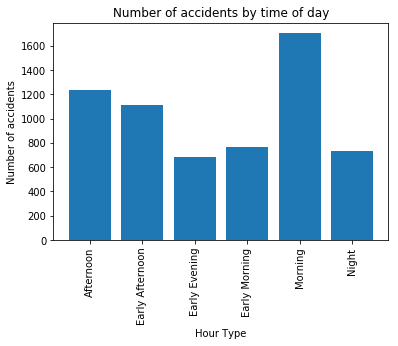

In [28]:
time_light_conditions=pd.merge(accidents_from_max_accidents_sa2, time_light_conditions,
                                       on="AccidentNu",
                                       how="inner")
time_light = group_by_data(time_light_conditions, ['LIGHT_CONDITION'])
time_light_conditions['HOUR_OF_DAY']=time_light_conditions.ACCIDENTTIME.apply(getTypeOfHourDay)
hour_light = group_by_data(time_light_conditions, ['HOUR_OF_DAY'])
hour_of_day=list(hour_light.HOUR_OF_DAY)
count_hour_of_day=list(hour_light['count'])
# The correlation between number of accidents and hour type is relatively strongly positive correlated. The coefficient value that we get
# is -0.09062326443452029. There is no correlation between the time of day and the number of accidents. There is no specific time of day where
# most of the accidents took place. The accidents are pretty much spread out.
print(calculate_correlation_coefficient(np.arange(len(hour_of_day)),count_hour_of_day))
plot_bar_plot(hour_of_day,count_hour_of_day, 'Hour Type', 'Number of accidents','Number of accidents by time of day')

In [29]:
'''image_link = """
    <div class='row'>
        <div class='col-md-12'>
            <img src='{0}' class='img-fluid'/>
            <center>
                <label>
                    Figure 4: This figure shows the spatial lag that has been calculated using Queen contiguity statistic which 
                    builds an index where if an area is a neighbor is given a value of 1 and 0 if not. Then the spatial lag is calculated
                    which tells how similar an area is similar to its neighbors.
                </label>
            </center>
        </div>
    </div>
    <br /><br />
    <div class='row'>    
        <div class='col-md-12'>

            <div class='row'>
                <div class='col-md-12'>
                <p>
                The Folium map shows where the clusters are exactly located further helping us in analyzing the data. We can see that 
                there is a high concentration of accidents on La Trobe Street so will be further examining the data for it.
                We decided to analyze this particular area because it contains the highest number of accidents in all of the SA2 areas.
                </p>
                </div>
            </div>

            <div class='row'>
                <div class='col-md-12'>
                {1}
                </div>
            </div>

        </div>
    </div>    

    <br /><br />
    <div class='row'>    
        <div class='col-md-12'>

            <div class='row'>
                <div class='col-md-12'>
                <p>
                    These table further give a better understanding of our accidents data that took place on La Trobe
                    Street.
                </p>
                </div>
            </div>

            <div class='row'>
                <div class='col-md-4'>
                <center>
                    {2}
                    <br />
                    Table 1: The table shows the number of parties that were involved in the accident. This further tells us how serious the accident was
                    due to the number of parties that were involved.
                </center>

                </div>
                <div class='col-md-4'>
                <center>
                    {3}
                    <br />
                    Table 2: The table shows the results of what the atmospheric and road conditions were at the time of the accident. We can see
                    that the majority of the severe accidents took place when the weather was clear and the road surface condition was dry.
                    There must be some other reason as to why the accidents took place.
                </center>
                </div>
                <div class='col-md-4'>
                <center>
                    {4}
                    <br />
                    Table 3: The table shows the number of drivers and their age groups who were involved in the accidents. 
                    The average age of the drivers was {7}.
                 </center>
                </div>
            </div>

        </div>
    </div>    

    <br /><br />
    <div class='row'>    
        <div class='col-md-12'>

            <div class='row'>
                <div class='col-md-6'>
                <center>
                {5}
                <br />
                Table 4: The table shows the gender statistics of drivers.
                </center>
                </div>

                <div class='col-md-6'>
                <center>
                {6}
                Table 5: The table shows the how many people wore their seatbelts/helmets and how many didnt.
                </center>
                </div>
            </div>

        </div>
    </div>

    """.format('dbscan_cluster.jpg', folium_map, number_parties_involved_html, group_by_atmos_surface_html,
               age_group_html, group_by_sex_html, helmet_belt_worn_html, average_driver_age)

html_content += build_html_component_with_html(image_link)'''

'image_link = """\n    <div class=\'row\'>\n        <div class=\'col-md-12\'>\n            <img src=\'{0}\' class=\'img-fluid\'/>\n            <center>\n                <label>\n                    Figure 4: This figure shows the spatial lag that has been calculated using Queen contiguity statistic which \n                    builds an index where if an area is a neighbor is given a value of 1 and 0 if not. Then the spatial lag is calculated\n                    which tells how similar an area is similar to its neighbors.\n                </label>\n            </center>\n        </div>\n    </div>\n    <br /><br />\n    <div class=\'row\'>    \n        <div class=\'col-md-12\'>\n\n            <div class=\'row\'>\n                <div class=\'col-md-12\'>\n                <p>\n                The Folium map shows where the clusters are exactly located further helping us in analyzing the data. We can see that \n                there is a high concentration of accidents on La Trobe Street

0.18816035355396343


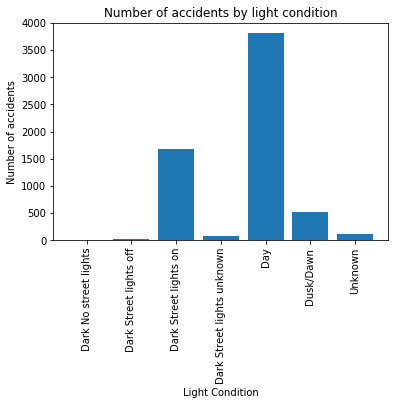

In [30]:
light_condition = list(time_light['LIGHT_CONDITION'].values)
count_time_light = list(time_light['count'].values)
# The correlation between number of accidents and age group are mostly not correlated. The coefficient value is extremely
# small and the value is 0.18816035355396343. There is no correlation at all. The r value is too small.
print(calculate_correlation_coefficient(np.arange(len(light_condition)),count_time_light))
plot_bar_plot(light_condition,count_time_light, 'Light Condition', 'Number of accidents','Number of accidents by light condition')

0.08708851613349221


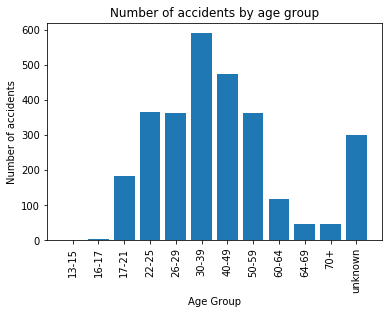

In [31]:
age_group = list(group_by_age_group['Age Group'].values)
count_age_group = list(group_by_age_group['count'].values)
# The correlation between number of accidents and age group is relatively weakly negative correlated. The coefficient value that we get
# is 0.08708851613349221. There is no correlation at all, but i can see a normal like distribution here.
print(calculate_correlation_coefficient(np.arange(len(age_group)),count_age_group))
plot_bar_plot(age_group,count_age_group, 'Age Group', 'Number of accidents','Number of accidents by age group')

-0.6172242797385701


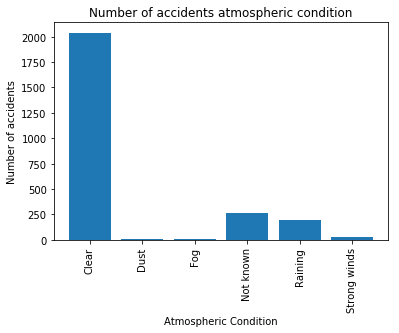

In [32]:
atmos_cond_desc = list(group_by_atmos_cond['AtmosCondDesc'].values)
count_atmos_cond_desc = list(group_by_atmos_cond['count'].values)
# The correlation between number of accidents and the atmospheric condition is strongly negative correlated. The coefficient value that we get
# is -0.6172242797385701. What this means is that the two variables are inverse of each other. This table shows that the accidents happening 
# on a clear day have a higher possibility than in any other atmospheric condition. However, we can not conclude that this is the sole reason 
# for the accidents happening. This might just be a coincidence that the accidents happened when the day was clear.
print(calculate_correlation_coefficient(np.arange(len(atmos_cond_desc)),count_atmos_cond_desc))
plot_bar_plot(atmos_cond_desc,count_atmos_cond_desc, 'Atmospheric Condition', 'Number of accidents','Number of accidents atmospheric condition')

-0.6955500701442592


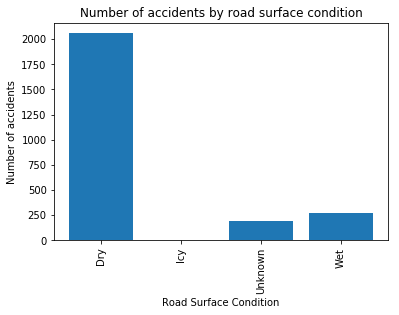

In [33]:
surface_cond_desc = list(group_by_road_surface['SurfaceCondDesc'].values)
count_surface_cond_desc = list(group_by_road_surface['count'].values)
# The correlation between number of accidents and the road surface condition is strongly negative correlated. The coefficient value that we get
# is -0.6955500701442592. What this means is that the two variables are inverse of each other.
htm_content = html_content + """


"""
print(calculate_correlation_coefficient(np.arange(len(surface_cond_desc)),count_surface_cond_desc))
plot_bar_plot(surface_cond_desc,count_surface_cond_desc, 'Road Surface Condition', 'Number of accidents','Number of accidents by road surface condition')

0.05570443965574384


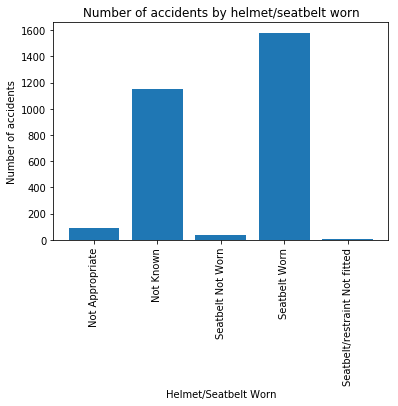

In [34]:
helmet_worn = list(group_by_helmet_worn['HELMET_BELT_WORN_CAT'].values)
count_helmet_worn = list(group_by_helmet_worn['count'].values)
# The correlation between number of accidents and the helmet/seatbelt worn is strongly positive correlated. The coefficient value that we get
# is 0.05570443965574384. There is no correlation.
print(calculate_correlation_coefficient(np.arange(len(helmet_worn)),count_helmet_worn))
plot_bar_plot(helmet_worn,count_helmet_worn, 'Helmet/Seatbelt Worn', 'Number of accidents','Number of accidents by helmet/seatbelt worn')


In [35]:


write_to_file(html_content, 'task3_922939.html', 'Task 3 922939')


In [36]:
accidents_data_frame_copy = accidents_data_frame.copy(deep=True)
accidents_data_frame_copy.rename(index=str, columns={'ACCIDENT_NO': 'AccidentNu'}, inplace=True)
accidents_with_severity = pd.merge(accidents_from_max_accidents_sa2, accidents_data_frame_copy,
                                                on="AccidentNu",
                                                how="inner")
accidents_with_severity = get_data_filtered_accident_date_for_year(accidents_with_severity, '2017', False)
accidents_with_severity_by_year = get_columns_from_data(accidents_with_severity,['AccidentNu', 'SEVERITY','ACCIDENTDATE'])
accidents_with_severity_by_year['YEAR'] = accidents_with_severity_by_year.ACCIDENTDATE.apply(lambda x: str(parse(x).year))
accidents_with_severity_by_year['Severity Description'] = accidents_with_severity_by_year.apply(
        assign_severity_description, axis=1)
accidents_with_severity_by_year.drop(columns=['ACCIDENTDATE','SEVERITY'],axis=1, inplace=True)
grouped_with_severity_year = group_by_data(accidents_with_severity_by_year, ['Severity Description', 'YEAR'])
pivoted_table_severity_year = grouped_with_severity_year.pivot(index='Severity Description', columns='YEAR', values='count')
pivoted_table_severity_year.fillna(0, inplace=True)

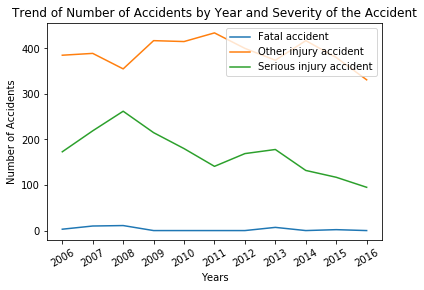

In [37]:
data=pivoted_table_severity_year.values
categories=pivoted_table_severity_year.index.values
start_index=2006
end_index=2017
title='Trend of Number of Accidents by Year and Severity of the Accident'
x_axis_label='Years'
y_axis_label='Number of Accidents'

fig, ax = plt.subplots()
index = np.arange(end_index - start_index)

x_labels = []
for i in range(start_index, end_index):
    x_labels.append(str(i))
# This list will be a 2D list. The first dimension will contain a list of severities (4 in our case) and then
# each element of that will contain 11 elements where each element is a year from 2006 to 2016.
# These elements will contain the number of accidents that took place in that year for that severity


for i, data in enumerate(data):
    ax.plot(index, data, label=categories[i])
    
ax.set_xlabel(x_axis_label, fontsize=10)
ax.set_ylabel(y_axis_label, fontsize=10)
ax.set_xticks(index)
ax.set_xticklabels(x_labels, fontsize=10, rotation=30)
ax.set_title(title)
ax.legend(loc='upper right', frameon=True)
plt.show()

In [38]:
accidents_with_year = pd.merge(accidents_from_max_accidents_sa2, accidents_data_frame_copy,
                                                on="AccidentNu",
                                                how="inner")
accidents_with_year = get_data_filtered_accident_date_for_year(accidents_with_year, '2017', False)

accidents_with_year = get_columns_from_data(accidents_with_year,['AccidentNu','ACCIDENTDATE'])
accidents_with_year['YEAR'] = accidents_with_year.ACCIDENTDATE.apply(lambda x: str(parse(x).year))
accidents_with_year.drop(columns=['ACCIDENTDATE'],axis=1, inplace=True)
grouped_by_years= group_by_data(accidents_with_year, ['YEAR'])

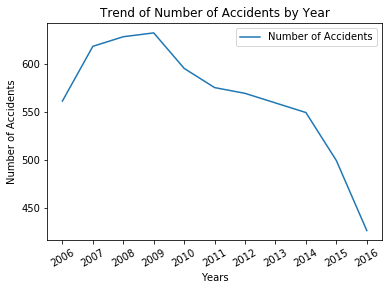

In [39]:
data=grouped_by_years['count'].values
categories=grouped_by_years['YEAR'].values
start_index=2006
end_index=2017
title='Trend of Number of Accidents by Year'
x_axis_label='Years'
y_axis_label='Number of Accidents'

fig, ax = plt.subplots()
index = np.arange(end_index - start_index)

x_labels = []
for i in range(start_index, end_index):
    x_labels.append(str(i))
# The results of this are quite unexpected. The graph shows that there has been a downward trend in the number of accidents over the years
# from 2006 to 2016. Infact in 2016 the lowest number of accidents took place. However, despite the downward trend, some actions do need to
# be taken by the Government of Victoria. The graph for the number of accidents by street shows us that work

ax.plot(index, data, label='Number of Accidents')
ax.set_xlabel(x_axis_label, fontsize=10)
ax.set_ylabel(y_axis_label, fontsize=10)
ax.set_xticks(index)
ax.set_xticklabels(x_labels, fontsize=10, rotation=30)
ax.set_title(title)
ax.legend(loc='upper right', frameon=True)
plt.show()